## Code generation

In [1]:
# initialize sympy printing (for latex output)
from sympy import init_printing, Symbol
init_printing()

# import functions and classes for compartment models
from compartor import *

Here, we illustrate how to export the moment equations in LaTeX format or generate code for simulations.

We consider again the exemplary model of the paper and derive moments equations with the automated function.

In [2]:
x = Content('x')
y = Content('y')

# Intake Distribution
pi_I = OutcomeDistribution.Poisson(Symbol('\pi_{I}(y; \lambda)'),y[0],Symbol('\lambda'))


Intake      = TransitionClass( {}        -to> [(y[0],0)],   'k_I', pi=pi_I, name='I')
Fusion      = TransitionClass( [x] + [y] -to> [x+y],        'k_F',          name='F')
Conversion  = TransitionClass( [x]       -to> [x + (-1,1)], 'k_c', x[0],    name='c')
Degradation = TransitionClass( [x]       -to> [x + (0,-1)], 'k_d', x[1],    name='d')

transitions = [ Intake, Fusion, Conversion, Degradation]
display_transition_classes(transitions)

Display.__str__: TODO

Computed moment equations for desired moments $\left< N\right> $, $\left< M^{\left(1, 0\right)}\right> $, $\left< {\left(M^{\left(1, 0\right)}\right)}^{2}\right> $, $\left< M^{\left(0, 1\right)}\right> $, and $\left< {\left(M^{\left(0, 1\right)}\right)}^{2}\right> $.

Equations were iteratively added for $\left< N^{2}\right> $ and $\left< M^{\left(0, 1\right)} M^{\left(1, 0\right)}\right> $.

Gamma closures were substituted for $\left< N^{3}\right> $.

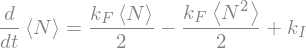

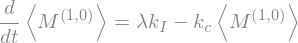

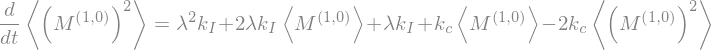

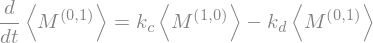

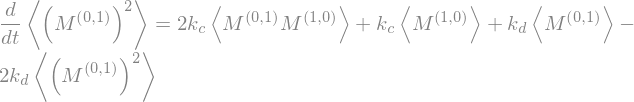

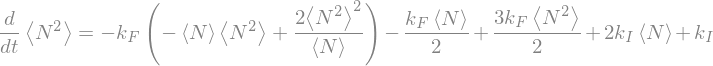

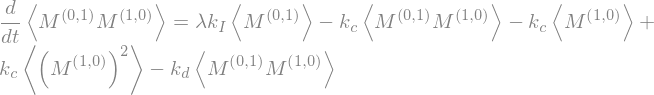

In [3]:
desired_moments = [Moment(0,0), Moment(1,0), Moment(1,0)**2, Moment(0,1), Moment(0,1)**2]
equations = automated_moment_equations(2, transitions, desired_moments)
display_moment_equations(equations)

The LaTeX source of the ODE system can be found and copy-pasted by modifying the Math Render option of the jupyter notebook. This is done by right-clicking on the system and choosing Math Settings > Math Render > Plain Source .

From the closed equations, we can also generate code to simulate the system. Currently, Python or Julia code can be generated.

For a direct code output, the user can rely on the functions:

In [4]:
python_code = generate_python_code(equations, function_name="example")
print(python_code)

# evaluate ODEs
def example_ODEs(M, dM, parameters):
  """
  Evaluate derivatives of expected moments
  
  Indices in M and dM vectors are 
    M[0] = Moment(0, 0)
    M[1] = Moment(1, 0)
    M[2] = Moment(1, 0)**2
    M[3] = Moment(0, 1)
    M[4] = Moment(0, 1)**2
    M[5] = Moment(0, 0)**2
    M[6] = Moment(0, 1)*Moment(1, 0)
  
  :param M: expected moments
  :param dM: result, the derivative dM/dt is stored here
  :param parameters: tuple of values for constants (\lambda, k_F, k_I, k_c, k_d)
  :return: dM
  """
  c3 = parameters[0] # \lambda
  c0 = parameters[1] # k_F
  c1 = parameters[2] # k_I
  c2 = parameters[3] # k_c
  c4 = parameters[4] # k_d
  # Number of Compartments (N)
  dM[0] = c1+1/2*c0*M[0]-1/2*c0*M[5]
  # Total Mass of species 1
  dM[1] = c3*c1-c2*M[1]
  # M1^2
  dM[2] = c3*c1+c1*c3**2+c2*M[1]-2*c2*M[2]+2*c3*c1*M[1]
  # Total Mass of species 2
  dM[3] = c2*M[1]-c4*M[3]
  # M2^2
  dM[4] = c2*M[1]+c4*M[3]-2*c4*M[4]+2*c2*M[6]
  # N^2
  dM[5] = c1+2*c1*M[0]-1/2*c0*M[0]+3/2*

or, for Julia code,

In [5]:
julia_code = generate_julia_code(equations, function_name="example")
print(julia_code)

# evaluate ODEs
function example_ODEs(dM, M, parameters, t)
  c0 = ??? # k_F, please specify!
  c1 = ??? # k_I, please specify!
  c2 = ??? # k_c, please specify!
  c3 = ??? # \lambda, please specify!
  c4 = ??? # k_d, please specify!
  # Number of Compartments (N)
  dM[1] = c1+1/2*c0*M[1]-1/2*c0*M[6]
  # Total Mass of species 1
  dM[2] = c3*c1-c2*M[2]
  # M1^2
  dM[3] = c3*c1+c1*c3^2+c2*M[2]-2*c2*M[3]+2*c3*c1*M[2]
  # Total Mass of species 2
  dM[4] = c2*M[2]-c4*M[4]
  # M2^2
  dM[5] = c2*M[2]+c4*M[4]-2*c4*M[5]+2*c2*M[7]
  # N^2
  dM[6] = c1+2*c1*M[1]-1/2*c0*M[1]+3/2*c0*M[6]+c0*M[6]*M[1]-2*c0*M[6]^2/M[1]
  # M2*M1
  dM[7] = c2*M[3]-c2*M[7]-c2*M[2]-c4*M[7]+c3*c1*M[4]
  return
end

# initialize expected moments vector
function example_initial(n0)
  M=zeros[7]
  # Number of Compartments (N)
  M[1] = ??? # initial value for Moment(0, 0), please specify!
  # Total Mass of species 1
  M[2] = ??? # initial value for Moment(1, 0), please specify!
  # M1^2
  M[3] = M[2]^2
  # Total Mass of spec

Both derive from a common `AbstractCodeGenerator` class, which allows the user to customize the code output with further implementation-specific details. The argument `function_name` gives sets the initial name of the two functions defined in the respective output:
* `function_name_ODEs()` implements the ODE system in the respective programming language,
* `function_name_initial()` is a supplementary function that computes the initial moments for a given initial configuration `n0` of the compartment population.

## Solving and Plotting results
We use the generated functions with `scipy.solve_ivp` to solve the system with the same initial condition and parameter values reported in the paper.

In [6]:
from scipy.integrate import solve_ivp
import numpy as np

exec(python_code) 

# vector of timepoints where to solve ODE problem
timepoints = np.linspace(0, 100, 1001)

# initial condition
# 1 compartment with 20 molecules of first species
M0 = example_initial((1, 20, 0))

# rate constants and other parameters
kI = 1.0
kF = 0.005
kc = 0.1
kd = 0.05
Lambda = 10
parameters = (Lambda, kF, kI, kc, kd)

# solve
sol = solve_ivp(
    lambda t, M: example_ODEs(M, np.zeros(7), parameters),
    (np.min(timepoints), np.max(timepoints)),
    M0,
    method='BDF',
    t_eval=timepoints)

# print solution of N
print(sol.y[5])

[  1.           1.30993662   1.63969989 ... 420.1743308  420.17551396
 420.17668693]


Finally, we use `matplotlib` to plot the solution for mean and standard deviation of $N$ and of the total amounts of molecules $M^{(1,0)}$ and $M^{(0,1)}$ for the two chemical species.

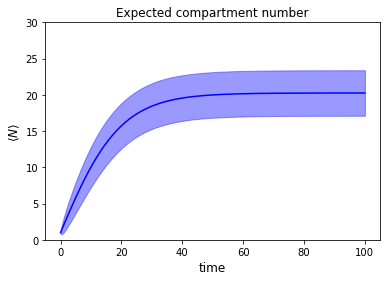

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

y = sol.y
N = y[0]
stdN = np.sqrt(y[5] - N**2)
plt.plot(timepoints, y[0], color="b")
plt.ylabel(r'$\left< N \right>$', size=12)
plt.xlabel('time', size=12)
plt.title("Expected compartment number", size=12)
plt.fill_between(timepoints, N-stdN, N+stdN, alpha=0.4, color="b")
plt.ylim((0,30))

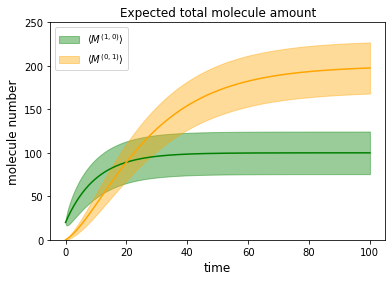

In [8]:
m1 = y[1]
stdm1 = np.sqrt(y[2] - m1**2)
m2 = y[3]
stdm2 = np.sqrt(y[4] - m2**2)
plt.plot(timepoints, m1, color="g")
plt.fill_between(timepoints, m1-stdm1, m1+stdm1, alpha=0.4, color="g",label=r'$\left< M^{(1,0)} \right>$')
plt.plot(timepoints, m2, color="orange")
plt.ylabel('molecule number', size=12)
plt.fill_between(timepoints, m2-stdm2, m2+stdm2, alpha=0.4, color="orange",label=r'$\left< M^{(0,1)} \right>$')
plt.xlabel('time', size=12)
plt.title("Expected total molecule amount", size=12)
plt.legend()
plt.ylim((0,250))